# Introduction

As we have considered in the experiment <a href='exp-HistogramMatching.ipynb'>`exp-HistogramMatching`</a>, the default feature detection is biased.

We know the relative position of image pieces and we can use this information to improve the performance of key detection and matching. In this experiment, we test how to use rough location in key detection.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
import cv2 as cv
import numpy as np
import math
import matplotlib.pyplot as plt
import copy
import time
import pandas as pd

from libpano import Config
from libpano import Preprocess
from libpano.ImageCropper import ImageCropper
from libpano.ImageFrame import ImageFrame
from libpano.Stitcher import Stitcher
from libpano.FocalCalculator import FocalCalculator
from libpano.MetaData import MetaData


In [3]:
image_id = 'office'
folder = '../test-image/' + image_id

meta = MetaData(folder)
df = meta.grid_data
metrics = meta.metrics
print(metrics)


Camera Metrics:
	Focal Length: 4.4589 mm
	Focal Length: 1588.26 px
	Sensor Size: 4.2447996 x 5.6447997 mm
	Pixels per mm: 356.20 x 357.14 px
PanoramaMetrics:
	Frame Count: 15 x 5
	Frame Size: 1512px x 2016px
	Interval Angle: 24.0︒ x 36.0︒
	AoV: 50.9081︒ x 64.6661︒
	AoV: 0.8885 x 1.1286
	PPR: 1701.7168px x 1786.2268px
	Panorama Size: 10692.2019px x 5611.5971px



# Other than White Wall

"White wall" problem, in which there is not enough key features in the frame, is one of the main problem in key detection and matching.

But except the `White Wall`, there are other problems in key detection and matching. In below, I will show the problem, which I named `Biased Keys`.

In [5]:
psr_df = pd.read_csv('/tmp/temp/framedata', header=None, names=['row', 'col', 'x', 'y', 'width', 'height'])
psr_df

row  col   x   y  width  height
0  img-r1-047.jpg -1079 1596  NaN NaN NaN    NaN     NaN
1   img-r1-073.jpg -340 1620  NaN NaN NaN    NaN     NaN

In [93]:
merged = pd.merge(df, psr_df, on=['row', 'col'], how='outer')
merged[merged.width > 1000]

row  col             uri      pitch      roll         yaw       x      y  \
24    2    4  img-r3-144.jpg -22.350544  3.706551  172.670227 -1965.0  321.0   
25    2    5  img-r3-178.jpg -23.230433  2.841674  207.149872 -1964.0  329.0   
34    3    4  img-r1-070.jpg   1.061107  0.933304  172.341553 -1965.0  594.0   
35    3    5  img-r1-108.jpg   1.975063  0.532751  210.551773 -1964.0  612.0   
44    4    4  img-r5-215.jpg  24.093849  1.202785  169.296997 -1965.0  875.0   
45    4    5  img-r5-250.jpg  25.634033 -0.190554  205.069351 -1965.0  885.0   

     width  height  
24  3931.0   723.0  
25  3929.0   700.0  
34  3931.0   707.0  
35  3930.0   705.0  
44  3931.0   726.0  
45  3930.0   708.0

In [94]:
def get_real_width(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    _, threshold = cv.threshold(gray, 5, 255, cv.THRESH_BINARY)
    contours, _ = cv.findContours(threshold, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    max_area = 0
    best_cnt = 0
    for cnt in contours:
        area = cv.contourArea(cnt)
        if area > max_area:
            max_area = area
            best_cnt = cnt
    x, y, w, h = cv.boundingRect(best_cnt)
    return w
    
def adjust_extreme_frames():
    extreme = merged[(merged.width > 1000)]
    for idx, record in extreme.iterrows():
        row = record['row']
        col = record['col']
        x = record['x']
        img = cv.imread('/tmp/temp/mask-{}-{}.jpg'.format(row, col))
        
        total_width = record['width']
        left_width = get_real_width(img[:, :int(total_width/2)])
        right_width = get_real_width(img[:, int(total_width/2):])
        
        real_width = left_width + right_width
        if left_width < right_width:
            x += total_width - right_width
        else:
            x -= right_width
            
        merged.at[idx, 'width'] = real_width
        merged.at[idx, 'x'] = x
        
adjust_extreme_frames()

In [95]:
merged

row  col             uri      pitch      roll         yaw       x      y  \
0     0    0  img-r4-035.jpg -70.459412  7.293012   25.835419     NaN    NaN   
1     0    1  img-r4-070.jpg -71.094116  7.779282   61.425293     NaN    NaN   
2     0    2  img-r4-107.jpg -71.051704  7.457036   97.851746     NaN    NaN   
3     0    3  img-r4-143.jpg -72.278793  7.608908  133.665466     NaN    NaN   
4     0    4  img-r4-181.jpg -71.861954  3.928496  171.979797     NaN    NaN   
5     0    5  img-r4-215.jpg -71.044380  6.490002  206.145676     NaN    NaN   
6     0    6  img-r4-252.jpg -71.053185  6.095496  242.718994     NaN    NaN   
7     0    7  img-r4-287.jpg -71.504265  6.724478  278.485657     NaN    NaN   
8     0    8  img-r4-323.jpg -70.439865  5.703634  314.153381     NaN    NaN   
9     0    9  img-r4-0-2.jpg -71.387100  4.859243  349.299408     NaN    NaN   
10    1    0  img-r2-322.jpg -46.529583  5.454153   28.331879     NaN    NaN   
11    1    1  img-r2-0-1.jpg -46.654022  1.693254   65.572815     NaN    NaN   
12    1    2  img-r2-035.jpg -46.224289  4.975187  101.070984     NaN    NaN   
13    1    3  img-r2-073.jpg -46.221653  6.042275  139.014587     NaN    NaN   
14    1    4  img-r2-108.jpg -46.125614  2.773438  174.006287     NaN    NaN   
15    1    5  img-r2-143.jpg -46.315689  4.732850  209.072495     NaN    NaN   
16    1    6  img-r2-179.jpg -46.370068  3.134949  245.636261     NaN    NaN   
17    1    7  img-r2-217.jpg -46.800419  3.360790  282.882507     NaN    NaN   
18    1    8  img-r2-250.jpg -46.671978  3.347015  316.526367     NaN    NaN   
19    1    9  img-r2-286.jpg -48.292625  5.426203  352.559631     NaN    NaN   
20    2    0  img-r3-0-1.jpg -23.978922  1.485439   28.141907  -163.0  373.0   
21    2    1  img-r3-035.jpg -23.406811  3.929132   63.519287   -41.0  309.0   
22    2    2  img-r3-070.jpg -22.579166  2.978227   99.224182   453.0  330.0   
23    2    3  img-r3-107.jpg -22.420263  3.774891  135.836792   852.0  347.0   
24    2    4  img-r3-144.jpg -22.350544  3.706551  172.670227  1296.0  321.0   
25    2    5  img-r3-178.jpg -23.230433  2.841674  207.149872 -2229.0  329.0   
26    2    6  img-r3-214.jpg -23.651903  1.748135  242.904968 -1826.0  336.0   
27    2    7  img-r3-250.jpg -22.723701  2.781480  279.041260 -1376.0  371.0   
28    2    8  img-r3-287.jpg -22.947998  3.845593  315.613098  -963.0  379.0   
29    2    9  img-r3-322.jpg -22.255884  3.206676  350.646820  -573.0  382.0   
..  ...  ...             ...        ...       ...         ...     ...    ...   
40    4    0  img-r5-072.jpg  25.244446  3.193602   26.559723  -108.0  867.0   
41    4    1  img-r5-108.jpg  25.912848  1.627074   62.537323   -89.0  893.0   
42    4    2  img-r5-143.jpg  25.426701  0.834067   97.533875   358.0  923.0   
43    4    3  img-r5-178.jpg  25.112972 -0.795784  132.905701   814.0  915.0   
44    4    4  img-r5-215.jpg  24.093849  1.202785  169.296997  1271.0  875.0   
45    4    5  img-r5-250.jpg  25.634033 -0.190554  205.069351 -2256.0  885.0   
46    4    6  img-r5-289.jpg  25.558666  0.408697  243.587067 -1820.0  916.0   
47    4    7  img-r5-323.jpg  23.952272  0.224958  277.428192 -1402.0  929.0   
48    4    8  img-r5-0-1.jpg  25.424170  0.522457  313.853027  -965.0  923.0   
49    4    9  img-r5-036.jpg  25.629736  1.197142  350.761871  -542.0  879.0   
50    5    0  img-r6-106.jpg  47.496799 -0.672394   23.968018     NaN    NaN   
51    5    1  img-r6-144.jpg  49.865433 -1.989559   61.678772     NaN    NaN   
52    5    2  img-r6-178.jpg  49.909328  0.408583   95.870636     NaN    NaN   
53    5    3  img-r6-214.jpg  49.716518 -2.353925  132.394043     NaN    NaN   
54    5    4  img-r6-251.jpg  49.663704 -0.470370  169.200378     NaN    NaN   
55    5    5  img-r6-287.jpg  49.348713  1.962751  204.950073     NaN    NaN   
56    5    6  img-r6-324.jpg  49.548908 -1.448622  241.646973     NaN    NaN   
57    5    7  img-r6-000.jpg  47.624828 -3.742552  277.876648     NaN    NaN   
58  

In [96]:
merged = merged.assign(cx=merged.x + merged.width / 2, xy=merged.y + merged.height / 2)
merged

row  col             uri      pitch      roll         yaw       x      y  \
0     0    0  img-r4-035.jpg -70.459412  7.293012   25.835419     NaN    NaN   
1     0    1  img-r4-070.jpg -71.094116  7.779282   61.425293     NaN    NaN   
2     0    2  img-r4-107.jpg -71.051704  7.457036   97.851746     NaN    NaN   
3     0    3  img-r4-143.jpg -72.278793  7.608908  133.665466     NaN    NaN   
4     0    4  img-r4-181.jpg -71.861954  3.928496  171.979797     NaN    NaN   
5     0    5  img-r4-215.jpg -71.044380  6.490002  206.145676     NaN    NaN   
6     0    6  img-r4-252.jpg -71.053185  6.095496  242.718994     NaN    NaN   
7     0    7  img-r4-287.jpg -71.504265  6.724478  278.485657     NaN    NaN   
8     0    8  img-r4-323.jpg -70.439865  5.703634  314.153381     NaN    NaN   
9     0    9  img-r4-0-2.jpg -71.387100  4.859243  349.299408     NaN    NaN   
10    1    0  img-r2-322.jpg -46.529583  5.454153   28.331879     NaN    NaN   
11    1    1  img-r2-0-1.jpg -46.654022  1.693254   65.572815     NaN    NaN   
12    1    2  img-r2-035.jpg -46.224289  4.975187  101.070984     NaN    NaN   
13    1    3  img-r2-073.jpg -46.221653  6.042275  139.014587     NaN    NaN   
14    1    4  img-r2-108.jpg -46.125614  2.773438  174.006287     NaN    NaN   
15    1    5  img-r2-143.jpg -46.315689  4.732850  209.072495     NaN    NaN   
16    1    6  img-r2-179.jpg -46.370068  3.134949  245.636261     NaN    NaN   
17    1    7  img-r2-217.jpg -46.800419  3.360790  282.882507     NaN    NaN   
18    1    8  img-r2-250.jpg -46.671978  3.347015  316.526367     NaN    NaN   
19    1    9  img-r2-286.jpg -48.292625  5.426203  352.559631     NaN    NaN   
20    2    0  img-r3-0-1.jpg -23.978922  1.485439   28.141907  -163.0  373.0   
21    2    1  img-r3-035.jpg -23.406811  3.929132   63.519287   -41.0  309.0   
22    2    2  img-r3-070.jpg -22.579166  2.978227   99.224182   453.0  330.0   
23    2    3  img-r3-107.jpg -22.420263  3.774891  135.836792   852.0  347.0   
24    2    4  img-r3-144.jpg -22.350544  3.706551  172.670227  1296.0  321.0   
25    2    5  img-r3-178.jpg -23.230433  2.841674  207.149872 -2229.0  329.0   
26    2    6  img-r3-214.jpg -23.651903  1.748135  242.904968 -1826.0  336.0   
27    2    7  img-r3-250.jpg -22.723701  2.781480  279.041260 -1376.0  371.0   
28    2    8  img-r3-287.jpg -22.947998  3.845593  315.613098  -963.0  379.0   
29    2    9  img-r3-322.jpg -22.255884  3.206676  350.646820  -573.0  382.0   
..  ...  ...             ...        ...       ...         ...     ...    ...   
40    4    0  img-r5-072.jpg  25.244446  3.193602   26.559723  -108.0  867.0   
41    4    1  img-r5-108.jpg  25.912848  1.627074   62.537323   -89.0  893.0   
42    4    2  img-r5-143.jpg  25.426701  0.834067   97.533875   358.0  923.0   
43    4    3  img-r5-178.jpg  25.112972 -0.795784  132.905701   814.0  915.0   
44    4    4  img-r5-215.jpg  24.093849  1.202785  169.296997  1271.0  875.0   
45    4    5  img-r5-250.jpg  25.634033 -0.190554  205.069351 -2256.0  885.0   
46    4    6  img-r5-289.jpg  25.558666  0.408697  243.587067 -1820.0  916.0   
47    4    7  img-r5-323.jpg  23.952272  0.224958  277.428192 -1402.0  929.0   
48    4    8  img-r5-0-1.jpg  25.424170  0.522457  313.853027  -965.0  923.0   
49    4    9  img-r5-036.jpg  25.629736  1.197142  350.761871  -542.0  879.0   
50    5    0  img-r6-106.jpg  47.496799 -0.672394   23.968018     NaN    NaN   
51    5    1  img-r6-144.jpg  49.865433 -1.989559   61.678772     NaN    NaN   
52    5    2  img-r6-178.jpg  49.909328  0.408583   95.870636     NaN    NaN   
53    5    3  img-r6-214.jpg  49.716518 -2.353925  132.394043     NaN    NaN   
54    5    4  img-r6-251.jpg  49.663704 -0.470370  169.200378     NaN    NaN   
55    5    5  img-r6-287.jpg  49.348713  1.962751  204.950073     NaN    NaN   
56    5    6  img-r6-324.jpg  49.548908 -1.448622  241.646973     NaN    NaN   
57    5    7  img-r6-000.jpg  47.624828 -3.742552  277.876648     NaN    NaN   
58  

In [97]:
merged = merged.assign(yaw=[yaw - 360 if yaw > 180 else yaw for yaw in merged.yaw])

In [98]:
pitch_and_y = merged[merged.x.notnull()].groupby(by='row')['pitch', 'y'].agg(np.mean)
pitch_and_y

pitch      y
row                  
2   -22.954563  347.7
3     1.476814  621.9
4    25.198969  900.5

In [99]:
np.diff(pitch_and_y['pitch'].values)

array([24.43137705, 23.72215479])

In [100]:
np.diff(pitch_and_y['y'].values)

array([274.2, 278.6])

In [101]:
np.mean(np.diff(pitch_and_y['y'].values) / np.diff(pitch_and_y['pitch'].values))

11.48378404548409

In [107]:
yaw_and_x = merged[merged.row == 3][['yaw', 'x']]
yaw_and_x

yaw       x
30   30.120270   -48.0
31   65.832825   127.0
32  102.442993   766.0
33  138.434143  1114.0
34  172.341553  1470.0
35 -149.448227 -2043.0
36 -115.823639 -1694.0
37  -80.150024 -1285.0
38  -42.539276  -915.0
39   -6.188782  -411.0

In [108]:
np.diff(yaw_and_x['yaw'].values)

array([  35.71255493,   36.61016846,   35.9911499 ,   33.90740967,
       -321.78977966,   33.62458801,   35.6736145 ,   37.61074829,
         36.35049438])

In [109]:
np.diff(yaw_and_x['x'].values)

array([  175.,   639.,   348.,   356., -3513.,   349.,   409.,   370.,
         504.])

In [110]:
np.diff(yaw_and_x['x'].values) / np.diff(yaw_and_x['yaw'].values)

array([ 4.90023747, 17.45416716,  9.66904367, 10.49918008, 10.91706518,
       10.37930933, 11.46505634,  9.83761336, 13.86501088])

In [111]:
np.mean(np.diff(yaw_and_x['x'].values) / np.diff(yaw_and_x['yaw'].values))

10.99852038491317

In [121]:
row = 1
col = 1
# merged[(merged.row == row + 1) & (merged.col == col), 'xy'].values[0]
merged[(merged.row == row + 1) & (merged.col == col)].xy.values[0]


664.5

### Good. Ten features were found for every pairs. And this approach has advantages as following:
##### 1. Matching performance
As we have seen in the examples, this approach can improve the performance of finding match points. It's not enought but `BETTER THAN NOTHING`!
##### 2. Fast feature detection
We search key points only in 40% area of the image and it makes the speed faster. NOTE: it is an advantage when two images were matched, but we should calculate at least 4 feature sets(top, bottom, left, and right).
##### 3. Fast matching
In precedent approaches, all possible images pairs are matched, so it takes O(n^2). But this method takes only O(4n). When we consider that we have about 80 images, matching speed is 20 times faster.

# Order of stitching
The main area of panorama contains the three middle rows. So we decided to stitch image pieces in the following order:

  10 <---------------------------   |    -----------------------------> 9 
  
   6  <-----------------------------   |    -----------------------------> 5
   
   2  <------------------------ CENTER ----------------------> 1
   
   4  <-----------------------------   |    -----------------------------> 3
   
   8  <-----------------------------   |    -----------------------------> 7


row = 2
uris = df[df.row == row].uri.values.tolist()
pitches = df[df.row == row].pitch.values.tolist()
yaws = df[df.row == row].yaw.values.tolist()
roll = df[df.row == row].roll.values.tolist()

# Step 1

In [155]:
center_row = df.row.nunique() // 2
center_col = df.col.nunique() // 2
print(center_row, center_col)

2 7


In [191]:
def get_image_frame(row, col):
    record = df[(df.row == row) & (df.col == col)]

    fn = record.uri.values[0]
    roll = record.roll.values[0]
    pitch = record.pitch.values[0]
    yaw = record.yaw.values[0]
    
    fpath = os.path.join(folder, fn)
    print(fpath)
    
    return ImageFrame(fpath, pitch, yaw, roll)
    

In [254]:
def is_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:, None]
        
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [301]:
def get_distance_horiz(left, right):
    img_width = metrics.FW
    
    x1 = int(img_width * 0.4)  # 40% point
    x2 = int(img_width * 0.6)  # 60% point

    features = []
    
    left_img = copy.deepcopy(left.contents)
    left_img[:, :x2, :] = 0
    feature = cv.detail.computeImageFeatures2(finder, left_img)
    features.append(feature)
    
    right_img = copy.deepcopy(right.contents)
    right_img[:, x1:, :] = 0
    feature = cv.detail.computeImageFeatures2(finder, right_img)
    features.append(feature)

    matcher = cv.detail.BestOf2NearestMatcher_create(False, 0.3)
    matches = matcher.apply2(features)
    
    for idx, match_info in enumerate(matches):
        start = time.perf_counter()

        src_idx = match_info.src_img_idx
        dst_idx = match_info.dst_img_idx

        if src_idx + 1 != dst_idx:
            continue

        # get inlier matches list
        matches_list = match_info.getMatches()
        matches_mask = match_info.getInliers().ravel().tolist()
        
        good_matches = [match for match, mask in zip(matches_list, matches_mask) if mask]
        good_matches = sorted(good_matches, key=lambda m: m.distance, reverse=False)
        good_matches = good_matches[:len(good_matches)//2]
        
        print([m.distance for m in good_matches])

        # get vertical, horizontal, and Euclidean distances
        kps1 = features[0].getKeypoints()
        kps2 = features[1].getKeypoints()
        
        vert_dists = [abs(kps1[m.trainIdx].pt[1] - kps2[m.queryIdx].pt[1]) for m in good_matches]
        horz_dists = [kps2[m.trainIdx].pt[0] + img_width - kps1[m.queryIdx].pt[0] for m in good_matches]
        eucl_dists = [math.sqrt(v**2 + h**2) for v, h in zip(vert_dists, horz_dists)]
        
        print(vert_dists)
        print(horz_dists)
        print(eucl_dists)

        outlier_flags = is_outlier(np.array(vert_dists)) * is_outlier(np.array(horz_dists)) * is_outlier(np.array(eucl_dists))
        print(outlier_flags)
        
        inlier_horz_dists = [horz for horz, outlier in zip(horz_dists, outlier_flags) if not outlier]
        
        print(len(inlier_horz_dists), np.mean(inlier_horz_dists))
        
        draw_params = dict(matchesMask=matches_mask,
                           singlePointColor=None,
                           matchColor=(0, 255, 0),
                           flags=2)
        res = cv.drawMatches(left.contents, 
                             features[src_idx].getKeypoints(),
                             right.contents, 
                             features[dst_idx].getKeypoints(),
                             matches_list, None, **draw_params)
        # draw key points
        res = cv.drawKeypoints(res, features[src_idx].getKeypoints(), outImage=None, color=(0, 0, 255), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        right_keypoints = features[dst_idx].getKeypoints()
        for kp in right_keypoints:
            kp.pt = (kp.pt[0] + width, kp.pt[1])
        res = cv.drawKeypoints(res, right_keypoints, outImage=None, color=(0, 0, 255), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

        plt.figure(figsize=(30, 20))
        plt.imshow(res)
        plt.title('match count={}'.format(np.sum(matches_mask)))
        plt.show()

        return len(inlier_horz_dists), np.mean(inlier_horz_dists)
        

../images/recent-04/img-r1-335.jpg
../images/recent-04/img-r1-000.jpg
[10.0, 13.0, 14.0, 19.0]
[1001.0399780273438, 1146.2400512695312, 127.296142578125, 121.0755615234375]
[986.8800048828125, 986.1119689941406, 987.8399963378906, 988.6694641113281]
[1405.707359889136, 1512.0459882317994, 996.0081155694035, 996.0555209748081]
[False False False False]
4 987.375358581543


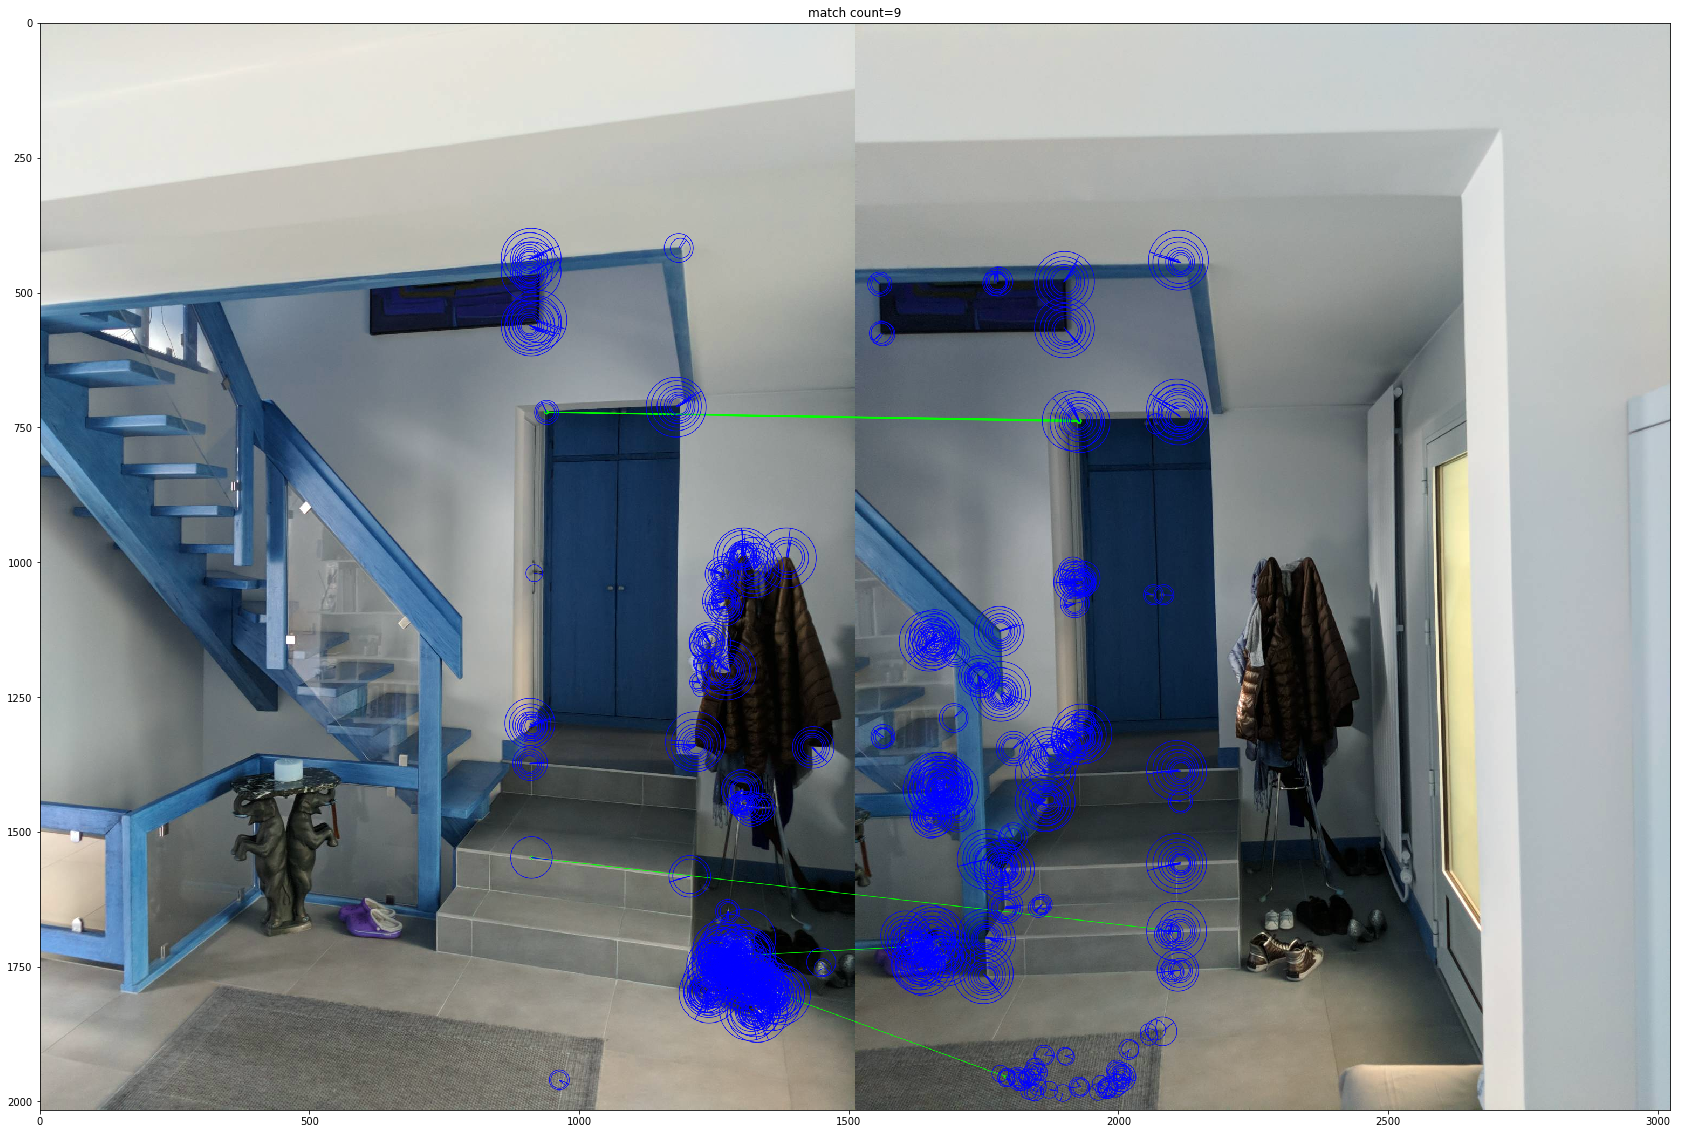

(4, 987.375358581543)

In [302]:
left = get_image_frame(2, 7)
left.load_image()

right = get_image_frame(2, 8)
right.load_image()

get_distance_horiz(left, right)

In [257]:
def adjust_extreme_frames():
    

[1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]

In [203]:
[match for match, mask in zip(matches_list, matches_mask) if mask]

[<DMatch 0x7f713c232810>,
 <DMatch 0x7f713cf140d0>,
 <DMatch 0x7f713cf145f0>,
 <DMatch 0x7f713cf14d10>]

In [204]:
matches_list

[<DMatch 0x7f713c232810>,
 <DMatch 0x7f713c232390>,
 <DMatch 0x7f713c397910>,
 <DMatch 0x7f713c1297b0>,
 <DMatch 0x7f713cf140d0>,
 <DMatch 0x7f713cf14130>,
 <DMatch 0x7f713cf145f0>,
 <DMatch 0x7f713cf14f70>,
 <DMatch 0x7f713cf14eb0>,
 <DMatch 0x7f713cf14fb0>,
 <DMatch 0x7f713cf14d10>,
 <DMatch 0x7f713cf14f90>,
 <DMatch 0x7f713cf14fd0>,
 <DMatch 0x7f713cf14f50>,
 <DMatch 0x7f713c3c68b0>]

In [198]:
good_matches = [matches_list[idx] if matches_mask[idx] == 1 for idx in range(len(matches_mask))]
good_matches

SyntaxError: invalid syntax (<ipython-input-198-45fda2727b7b>, line 1)

../images/recent-04/img-r1-335.jpg
../images/recent-04/img-r1-000.jpg


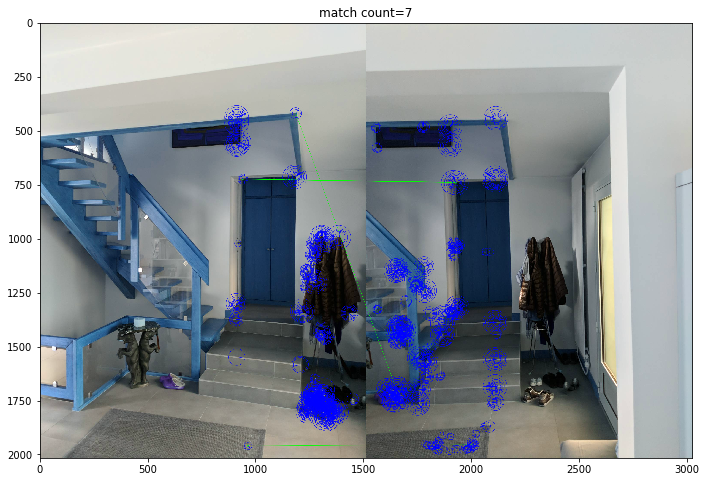

../images/recent-04/img-r1-022.jpg


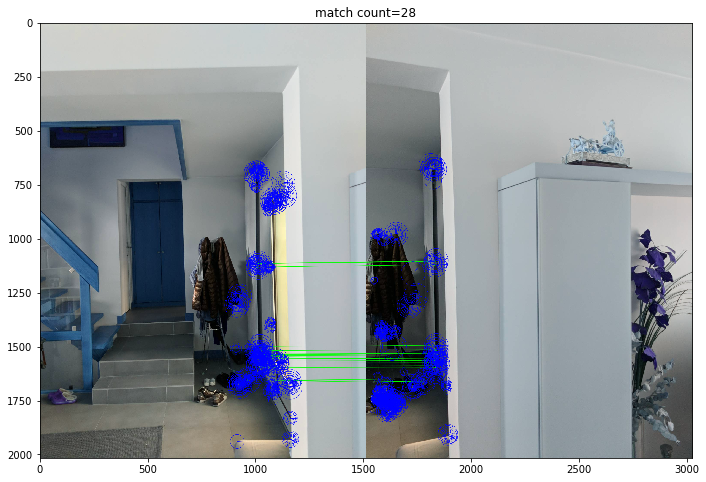

../images/recent-04/img-r1-048.jpg


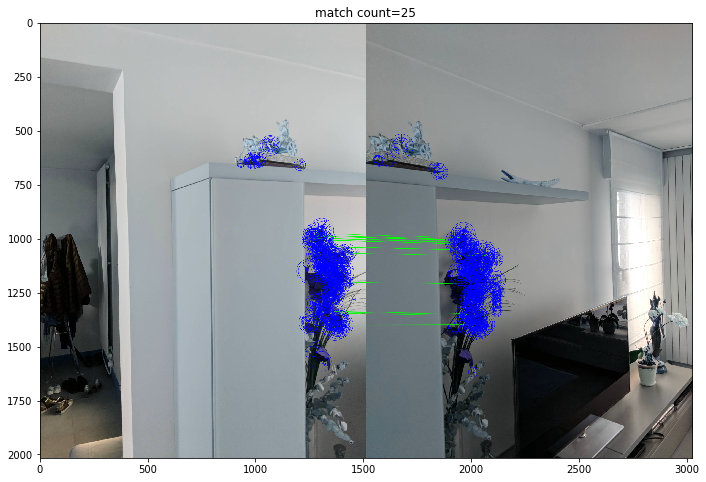

../images/recent-04/img-r1-070.jpg


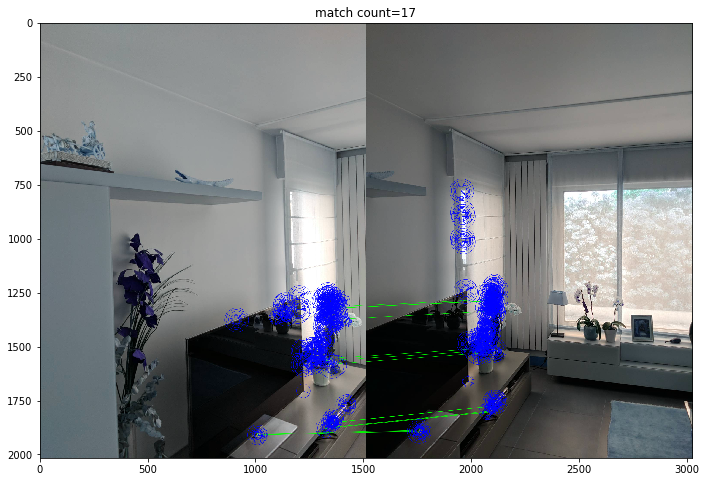

../images/recent-04/img-r1-095.jpg


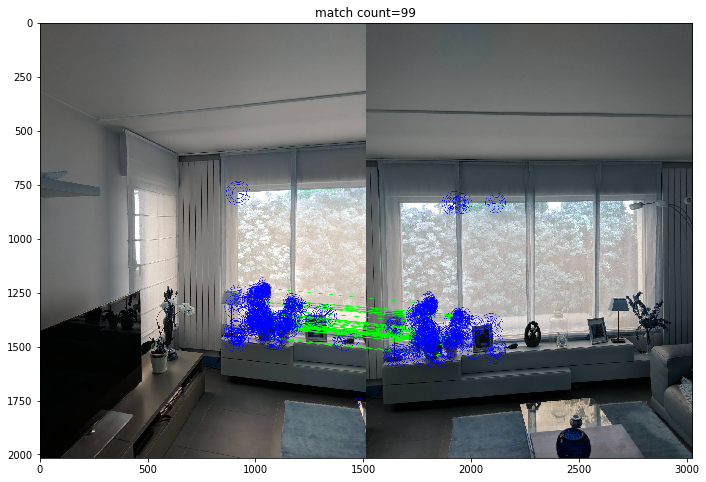

../images/recent-04/img-r1-118.jpg


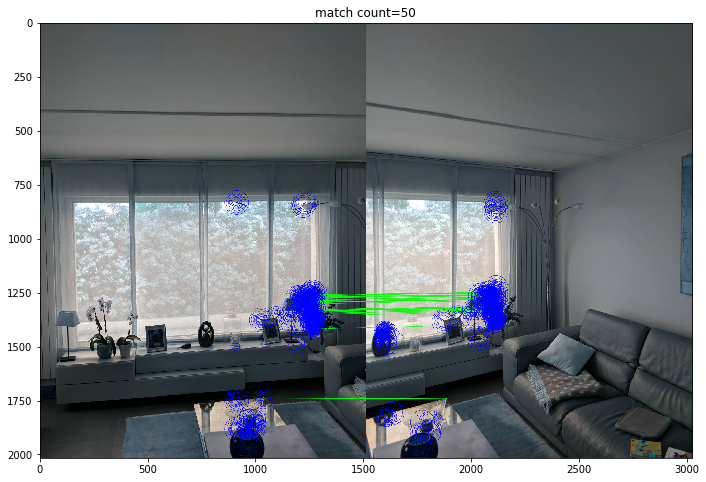

../images/recent-04/img-r1-143.jpg


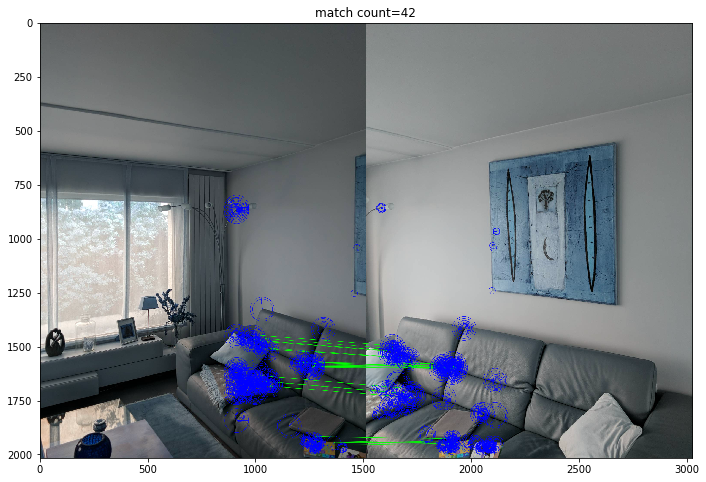

In [179]:
right_image = get_image_frame(center_row, center_col)
right_image.load_image()

for i in range(1, 8):
    left_image = right_image

    right_image = get_image_frame(center_row, center_col + i)
    right_image.load_image()
    
    get_distance_horiz(left_image, right_image)

In [173]:
df[df.row==2]

row  col             uri     pitch      roll         yaw
30    2    0  img-r1-167.jpg  1.618314  0.672979   17.196747
31    2    1  img-r1-192.jpg  1.405421 -0.227626   41.420685
32    2    2  img-r1-217.jpg  1.407111  1.317603   66.893280
33    2    3  img-r1-240.jpg  1.669483  1.424618   89.764771
34    2    4  img-r1-264.jpg  1.795640  0.912027  113.928802
35    2    5  img-r1-286.jpg  0.791613  0.535418  136.117828
36    2    6  img-r1-310.jpg  1.689086  1.997290  160.312744
37    2    7  img-r1-335.jpg  1.852506  3.240176  185.285416
38    2    8  img-r1-000.jpg  1.814764  1.945364  209.926773
39    2    9  img-r1-022.jpg  1.616959  2.058648  232.099152
40    2   10  img-r1-048.jpg  1.781996  2.166965  257.511200
41    2   11  img-r1-070.jpg  1.651889  1.609781  280.285095
42    2   12  img-r1-095.jpg  1.863805  1.228925  304.976898
43    2   13  img-r1-118.jpg  1.534545  1.944360  328.037811
44    2   14  img-r1-143.jpg  1.842209  1.463921  353.075012

In [190]:
def is_outlier(points, thresh=1.2):
    if len(points.shape) == 1:
        points = points[:, None]
        
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [189]:
is_outlier(np.array([150, 50, 23, 28, 15, 17, 38, 16, 25, 17, .5, 10]))

array([ True,  True, False, False, False, False,  True, False, False,
       False,  True,  True])

In [5]:
df[df.row==2]

row  col             uri     pitch      roll         yaw
30    2    0  img-r1-167.jpg  1.618314  0.672979   17.196747
31    2    1  img-r1-192.jpg  1.405421 -0.227626   41.420685
32    2    2  img-r1-217.jpg  1.407111  1.317603   66.893280
33    2    3  img-r1-240.jpg  1.669483  1.424618   89.764771
34    2    4  img-r1-264.jpg  1.795640  0.912027  113.928802
35    2    5  img-r1-286.jpg  0.791613  0.535418  136.117828
36    2    6  img-r1-310.jpg  1.689086  1.997290  160.312744
37    2    7  img-r1-335.jpg  1.852506  3.240176  185.285416
38    2    8  img-r1-000.jpg  1.814764  1.945364  209.926773
39    2    9  img-r1-022.jpg  1.616959  2.058648  232.099152
40    2   10  img-r1-048.jpg  1.781996  2.166965  257.511200
41    2   11  img-r1-070.jpg  1.651889  1.609781  280.285095
42    2   12  img-r1-095.jpg  1.863805  1.228925  304.976898
43    2   13  img-r1-118.jpg  1.534545  1.944360  328.037811
44    2   14  img-r1-143.jpg  1.842209  1.463921  353.075012